---

 __curso [Introducción a la programación HPC con Python y sus aplicaciones al campo de proceso de imágenes]([https://ig.conae.unc.edu.ar/introduccion-a-la-programacion-hpc-2025/])__

Simulador de Circuitos Cuánticos, acelerado por MPI y/o GPU. ver [README.md](https://github.com/eterX/CP33simu/blob/main/README.md)

---
# Sección 0


Inicialización de la biblioteca `cp33simu`, el entorno y variables globales.

Validamos que el stack está instalado y funcionando. Como se probó en gColab (cuenta gratuita) con entorno T4, CuPY falló en instalar. Como alternativa se instaló el stack en una portátil con GPU NVDIA GTX 960M (compute capability 5.0). Se muestran resultados abajo.

In [10]:
#Inicialización del entorno y variables globales

%load_ext autoreload
%autoreload 2
import qiskit as qk
import sympy as sp
import cp33simu


# globales (perdón Niklaus) TODO: mandar a archivo de config
num_qubits = 5  #número de qubits a simular
corridas = 30 #corridas del Aer de benchmark


## verificamos CUDA y cupy
_=list()
_.append(qk.QuantumCircuit(1,0))
_[-1].h(0)
_.append(cp33simu.simuGPU(qc=_[-1]))
try:
    if not _[-1].cupy_installed():
        # hay problemas con Cupy
        raise ImportError("Cupy no está instalado")
    if not _[-1].validate_cupy():
        raise ImportError("Cupy no está funcionando bien")
except ImportError as e:
        print(f"WARN: {e}")
except Exception:
        raise
finally:
    print(f"INFO: **{cp33simu.cupy.__name__}** funciona bien, v{cp33simu.cupy.__version__}")
    for tmp in _:
        del(tmp) # borro temporales

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DEBUG: Versión de CuPy: 13.6.0, GPU: b'NVIDIA GeForce GTX 960M'
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1490.69 ms
DEBUG: GPU.compute_capability: 50
INFO: Simulador creado: circuit-51
INFO: Qbits  1
DEBUG: Versión de CuPy: 13.6.0, GPU: b'NVIDIA GeForce GTX 960M'
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1482.92 ms
DEBUG: GPU.compute_capability: 50
INFO: **cupy** funciona bien, v13.6.0


### Arquitectura del módulo `cp33simu`

El módulo tiene un patrón de herencia, la clase base abstracta `simuAbstracto` es la interfaz común para todos los simuladores:
- `qc_matrix_load()`: Carga la matriz del circuito cuántico
- `instate_matrix_load()`: Prepara el estado inicial
- `outstate_calculate()`: Calcula la evolución

luego:


 1. `simuGPU`: Simulador GPU de usando [CuPy](https://docs.cupy.dev/en/stable/overview.html), a alto nivel: "a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python". Implementa:
- Validación de CuPy con benchmarks
- Conversión de circuito Qiskit a matriz en GPU (complex128)
- Construcción de estado inicial mediante productos de tensriales
- Evolución por multiplicación matricial acelerada en GPU

 2. `simuGPUbajo`: mismo que simuGPU pero con implementación de kernels CUDA de bajo nivel con CuPY. No implementado

 3. `simuMPI`: Misma simulación pero distribuida con descomposición de dominio. El vector de estado se particiona entre procesos MPI. No implementado



# sección 1 - Qiskit-Aer

## estado |+....+> con qiskit-aer

Preparamos el estado  |+....+> y  simulamos con el StateVector sampler de `qiskit-aer`. Usaremos éste resultado para comparar con la biblioteca `cp33simu`

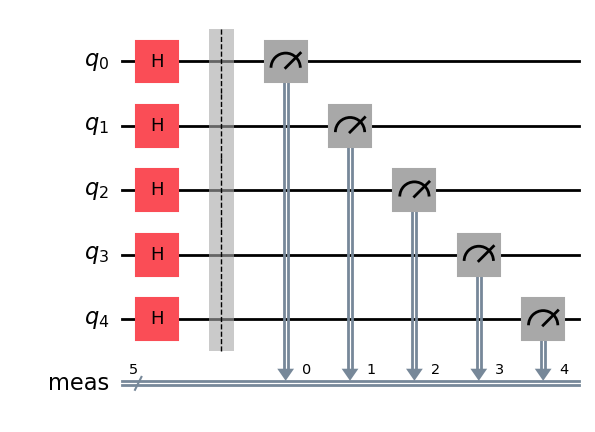

In [11]:


qc1=qk.QuantumCircuit(num_qubits,0)
qc1.h(range(num_qubits))
qc1_copy=qc1.copy()
qc1_copy.measure_all()
display(qc1_copy.draw(output='mpl'))

In [12]:
# simulamos

from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
job = sampler.run([qc1_copy], shots = corridas)
result = job.result()
result_data = result[0].data
data_as_bitstrings = result_data.meas.get_bitstrings()
cuantosMuestro=min(corridas,10) # no mas de diez, por si se queda muy largo
data_as_bitstrings[-cuantosMuestro:]

['10101',
 '10000',
 '01001',
 '01001',
 '00010',
 '10010',
 '10000',
 '10110',
 '01110',
 '11010']

In [13]:
result_data.meas

BitArray(<shape=(), num_shots=30, num_bits=5>)

---
# sección 2-  simulación con CuPy/GPU


Implementamos nuestro  simulador (prueba de concepto) usando CuPy para acelerar las operaciones matriciales en GPU.
1. **Carga del circuito como matriz**: Convertimos el circuito cuántico a su representación matricial usando `qk.quantum_info.Operator.from_circuit()` y lo pasamos a la GPU con `cupy.array()`. Para 5 qubits es una matriz de 32x32 complejos (complex128)

2. **Estado inicial**: Construimos $\ket{0...0}$ usando producto tensorial (`cupy.kron()`).

3. **Evolución del estado**: $\ket{ψ_{out}} = U\ket{ψ_{in}}$.  trabajo ideal para hacer directamente en la GPU, suponiendo que la memoria global es suficiente. El Offloading a GPU evita transferencias $CPU <-> GPU$.  El problema  circuitos grandes crece exponencialmente (2^n × 2^n complejos). Un circuito de 20 qubits ya requiere ~17GB solo para la matriz U.




## estado |+....+> con GPU



In [14]:
#TODO: si simu.cupy_enabled en falso, saltea la sección

In [15]:
# instanciamos el simulador para GPU en `cp33simu` con el circuito a simular
#
# este usar CuPY a "alto nivel", `cp33simu.simuGPUbajo`

simu=cp33simu.simuGPU(qc=qc1)

# otras opciones NO IMPLEMENTADAS:
#simu=cp33simu.simuGPUbajo(qc=qc1)
#simu=cp33simu.simuMPI(qc=qc1)

DEBUG: Versión de CuPy: 13.6.0, GPU: b'NVIDIA GeForce GTX 960M'
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1489.89 ms
DEBUG: GPU.compute_capability: 50
INFO: Simulador creado: circuit-52
INFO: Qbits  5


In [16]:
# saca la matriz desde qiskit
# para preparar |+...+> la mariz del circuito será (H|0⟩)⊗...⊗(H|0⟩)
#
simu.qc_matrix=None
resultOK=simu.qc_matrix_load() #carga la matriz del circuito en la GPU
#resultOK=False
if resultOK:
    pass #TODO: mostramos matriz?
else:
    msg="no se pudo cargar la matriz del circuito"
    print(f"ERROR: {msg}")
    raise ValueError(msg)

# preparamos el estado inicial
simu.instate_matrix=None
resultOK=simu.instate_matrix_load()
if not resultOK:
    msg="ERROR: no se pudo cargar el estado de entrada"
    raise ValueError(msg)


#todo listo, simulamos!
resultOK=simu.outstate_calculate()

INFO: Estado inicial cargado: [[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j -0.1767767+0.j]
 ...
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]]
INFO: Estado inicial cargado
DEBUG: Estado inicial: [[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j

In [17]:

if not resultOK:
    print("ERROR: no se pudo calcular el estado de salida")
else:
    print(f"INFO: estado de salida OK, primeras filas: \n {simu.outstate_matrix[-cuantosMuestro:]}")

INFO: estado de salida OK, primeras filas: 
 [[0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]]


---
# sección 3 - Vector de Estados distribuído con MPI


Esta sección está pendiente de implementación. La idea es usar `mpi4py` para distribuir el vector de estado entre múltiples procesos (potencialmente en diferentes nodos de un cluster).  Cada proceso MPI maneja una porción del vector. Las compuertas multi-qbit requieren comunicación entre procesos cuando hay entrelazamiento , se espera ver ventajas con MPI versus GPU aisladas.

TODO: implementar simu33.simuMPI

---
# sección 4 - conclusiones





## sobre la Sección 0: Inicialización del entorno y variables globales

Se valida que el stack está instalado y funcionando, distinguiendo entre entorno con CUDA(cupy/GPU) y sin CUDA (solo para MPI).
En el primer caso se lee:"INFO: **cupy** funciona bien, v13.6.0" y en el segundo "INFO: **numpy** funciona bien, v".

Para el desarrollar con el stack con CuPY, se usó una GTX 960M (compute capability 5.0) local, y sirvió bien como PoC. El benchmark de multiplicación de matrices 10000x10000 en ~1.5 segundos parece razonable.

### `cc33simu`

el diseño sirvió: Separar la interfaz de la implementación nos permite comparar diferentes estrategias de HPC (GPU alto nivel, GPU bajo nivel, MPI distribuido) usando la misma API.



## sobre la Sección 1: Estado |+....+> con qiskit-aer

Acá usamos el `StatevectorSampler` de Qiskit para simular el estado de máxima superposición. Es  la referencia contra la cual vamos a comparar nuestro simulador. 30 corridas nos dan un sampling decente del espacio de estados - todos los bitstrings salen con probabilidad uniforme, se espera a la salida de la compuerta Hadamard H|0> da |+>. El `StatevectorSampler` es la forma "oficial" de hacer esto en Qiskit.

## sobre la Sección 2: Simulación con CuPy/GPU

 DEmostramos que se puede  simular usando CuPy. El resultado muestra todas las amplitudes en √(1/32) ≈ 0.177, que es lo esperado para el estado |+...+⟩. Matemáticamente correcto, y acelerando con GPU.


## Sección 3: Vector de Estados distribuido con MPI

WIP


## Infraestructura

- **Google Colab**: Intentamos usar Colab pero no funcionó. Probablemente por restricciones en el runtime o versiones incompatibles de CUDA/CuPy.

- **Notebook local con GPU**: Terminamos instalando CUDA y CuPy en una máquina local con una GPU geforce GTX 960M

A veces la infraestructura "gratis" de la nube no es tan flexible como tu propio HW donde hay control total del stack.

### Trabajo Futuro

#### 1. Implementación de `simuGPUbajo` con kernels CUDA (~24 horas)

 Implementar operaciones cuánticas usando kernels CUDA custom en vez de operaciones de alto nivel de CuPy. Beneficio esperado, Los kernels custom pueden aprovechar mejor la memoria compartida de la GPU y optimizar patrones de acceso a memoria.

#### 2. Simulación distribuida con MPI - `simuMPI` (~32 horas)

Implementar descomposición de dominio del statevector usando MPI para superar limitaciones de memoria de un solo nodo.
